# Lab 6 - Denoising

In this lab we will use denoising to clean up some noisy recordings. We will use the following sounds:

Speech in a room: [https://drive.google.com/uc?export=download&id=1g5nbBpNbCjqs8cSoW0Lb-owe15tswDwW ]

ATC: [https://drive.google.com/uc?export=download&id=1fh5iL5qRj3-PUP_sG5-QE5DofACY_Hr5 ]

Speech with wind: [https://drive.google.com/uc?export=download&id=1g7TIkLpnWDFNUQYgCqIUoSOkk5EIK16_ ]



## Part 1. Cleaning up the sounds

Let’s start by cleaning up these sounds as best as we can. We will do a straightforward magnitude spectral subtraction. For all of these sounds there is only noise in the first few seconds of the recording so that you can learn a noise profile from there. Do the following:
Perform an STFT of the recordings

- Estimate the magnitude spectrum of the noise from the beginning of the recording
    - It’s up to you to figure out how many seconds to use (hint: look at the spectrogram)

- Perform spectral subtraction by subtracting that spectrum from the input’s magnitude STFT
    - Remember to clip any resulting negative values to zero
    - Try to find how much of the noise to subtract so that the output looks good

- Use the original signal’s phase to convert back to a time series.

Make a note of which examples sound the best and are easier to work with. Try to explain why.
At this point some of the outputs will exhibit “musical noise”. To minimize its effects apply a median filter on the denoised magnitude spectrogram to make it sound better (hint: ```scipy.signal.medfilt2```). How big should the median window be? Try different values and find which work best.


In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

In [3]:
def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # Zero padding to front and end of the input
    zero_padding = np.zeros(dft_size)
    x = np.append(zero_padding, input_sound)
    x = np.append(x, zero_padding)

    # Segment into shorter frames
    frames = []
    for i in range(0, len(x)-dft_size, hop_size):
        # Apply analysis window
        frames.append(x[i:i+dft_size] * window)

    f = []
    for frame in frames:
        freq_vec = np.reshape(np.fft.rfft(frame, dft_size+zero_pad), (-1, 1))
        f.append(freq_vec)

    # Return a complex-valued spectrogram (frequencies x time)
    return np.hstack(f)

def istft( stft_output, dft_size, hop_size, zero_pad, window):
    t = []
    for f in stft_output.T:
        t.append(np.fft.irfft(f, dft_size+zero_pad))
    t = np.array(t)

    x = np.zeros(dft_size+hop_size*(len(t)-1))
    for i in range(len(t)):
        x[i*hop_size:i*hop_size+dft_size] += t[i][:dft_size] * window
    
    # Return reconstructed waveform
    return x[dft_size:]

# Plot all the spectrograms
def plot_spectrogram(x, X, fs, title='', add_value=np.e):
    time_axis = np.linspace(0, len(x)/fs, X.shape[1])
    freq_axis = np.linspace(0, fs/2, X.shape[0])
    freq_abs = np.absolute(X)
    plt.pcolormesh(np.arange(freq_abs.shape[1]), freq_axis, np.log(freq_abs + add_value), cmap='Blues')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Freq (Hz)')
    plt.show()

In [4]:
fs_room, x_room = wavfile.read('data/room-speech.wav')
fs_atc, x_atc = wavfile.read('data/aircomm.wav')
fs_wind, x_wind = wavfile.read('data/wind-speech.wav')

In [5]:
dft_size = 1024
hop_size = 256
zero_pad = 0
window = signal.hann(dft_size, sym=False)

X_room = stft(x_room, dft_size, hop_size, zero_pad, window)
X_atc = stft(x_atc, dft_size, hop_size, zero_pad, window)
X_wind = stft(x_wind, dft_size, hop_size, zero_pad, window)

In [6]:
def spectral_subtraction(X, N, alpha):
    Y = []
    for Xi in X.T:
        magnitude = (np.abs(Xi) - alpha * np.abs(N)).clip(min=0)
        Yi = magnitude * np.exp(1j * np.angle(Xi))
        Y.append(Yi)
    Y = np.array(Y).T
    return Y

def median_filtering(X, Y, kernel_size):
    """
    X: Original spectrogram
    Y: Denoised spectrogram
    kernel_size: Kernel size for median filtering
    """
    Z = signal.medfilt2d(np.abs(Y), kernel_size)
    Z = Z.astype(np.complex128) # change dtype to complex

    for j in range(Z.shape[1]):
        Z[:, j] = np.abs(Z[:, j]) * np.exp(1j * np.angle(X[:, j]))
        
    return Z

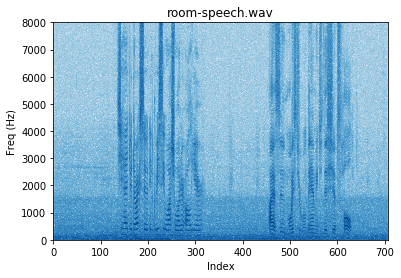

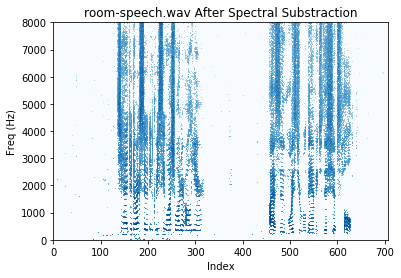

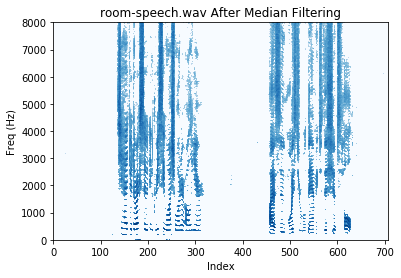

In [7]:
# room-speech.wav
N_room = np.abs(X_room[:, :100])
N_room = np.mean(N_room, axis=1)
Y_room = spectral_subtraction(X_room, N_room, alpha=3)
y_room = istft(Y_room, dft_size, hop_size, zero_pad, window=1/2)

# Median filtering
Z_room = median_filtering(X_room, Y_room, 3)
z_room = istft(Z_room, dft_size, hop_size, zero_pad, window=1/2)

plot_spectrogram(x_room, X_room, fs_room, 'room-speech.wav')
plot_spectrogram(x_room, Y_room, fs_room, 'room-speech.wav After Spectral Substraction')
plot_spectrogram(x_room, Z_room, fs_room, 'room-speech.wav After Median Filtering')

sound(x_room, fs_room, 'room-speech.wav')
sound(y_room, fs_room, 'room-speech.wav After Spectral Substraction')
sound(z_room, fs_room, 'room-speech.wav After Median Filtering')

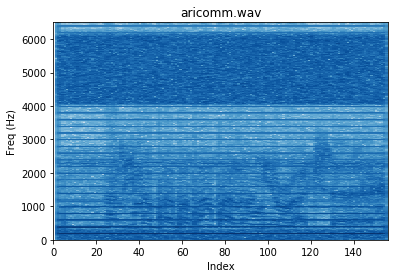

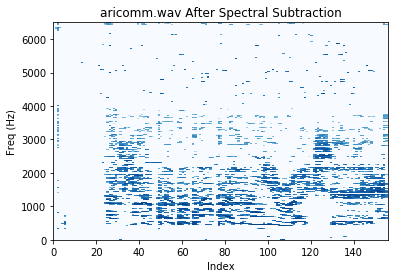

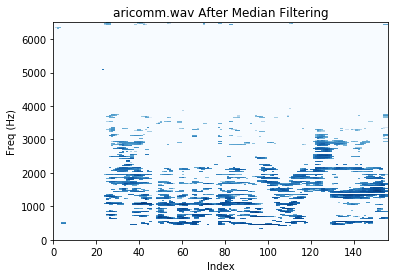

In [8]:
# aricomm.wav
N_atc = np.abs(X_atc[:, :20])
N_atc = np.mean(N_atc, axis=1)
Y_atc = spectral_subtraction(X_atc, N_atc, alpha=3)
y_atc = istft(Y_atc, dft_size, hop_size, zero_pad, window=1/2)

# Median filtering
Z_atc = median_filtering(X_atc, Y_atc, 3)
z_atc = istft(Z_atc, dft_size, hop_size, zero_pad, window=1/2)

plot_spectrogram(x_atc, X_atc, fs_atc, 'aricomm.wav')
plot_spectrogram(x_atc, Y_atc, fs_atc, 'aricomm.wav After Spectral Subtraction')
plot_spectrogram(x_atc, Z_atc, fs_atc, 'aricomm.wav After Median Filtering')

sound(x_atc, fs_atc, 'aricomm.wav')
sound(y_atc, fs_atc, 'aricomm.wav After Spectral Subtraction')
sound(z_atc, fs_atc, 'aricomm.wav After Median Filtering')

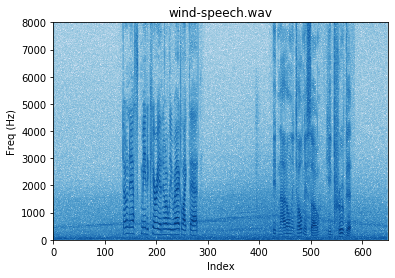

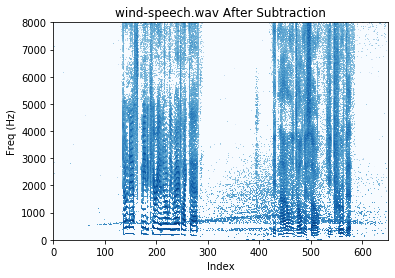

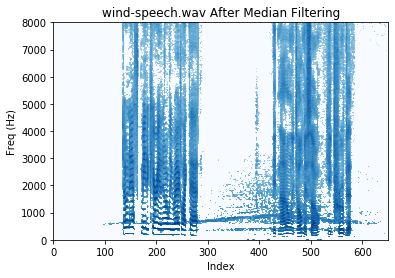

In [9]:
# wind-speech.wav
N_wind = np.abs(X_wind[:, :100])
N_wind = np.mean(N_wind, axis=1)
Y_wind = spectral_subtraction(X_wind, N_wind, alpha=3)
y_wind = istft(Y_wind, dft_size, hop_size, zero_pad, window=1/2)

# Median filtering
Z_wind = median_filtering(X_wind, Y_wind, 3)
z_wind = istft(Z_wind, dft_size, hop_size, zero_pad, window=1/2)

plot_spectrogram(x_wind, X_wind, fs_wind, 'wind-speech.wav', 1e-5)
plot_spectrogram(x_wind, Y_wind, fs_wind, 'wind-speech.wav After Subtraction', 1e-5)
plot_spectrogram(x_wind, Z_wind, fs_wind, 'wind-speech.wav After Median Filtering', 1e-5)

sound(x_wind, fs_wind, 'before denoising')
sound(y_wind, fs_wind, 'after denoising')
sound(z_wind, fs_wind, 'wind-speech.wav After Median Filtering')

Room speech is easier to work with, and it is because the noise is almost stable. On the other hand, noises from wind are more dynamic and that caused some noise after spectral substraction. Finally, ATC is the hardest one to denoise because of the randomness at high frequency.

## Part 2. Implement a Voice Activity Detector (VAD)


For the last sound we have an evolving noise profile, which causes problems since our noise description from the first two seconds isn’t accurate throughout. Because we’re lazy we want to automatically update the noise model and not to select it manually. To do so we need a VAD that lets us know when to gather noise statistics and when to denoise. Do the following:

- Take the square of the input waveform and lowpass filter it (a lot) to get an energy level over time
    - Experiment with the cutoff frequency so that you get a smooth energy-looking function
- Set a threshold over which we seem to have speech in the input
- Implement a real-time spectral subtraction denoiser
    - If an input frame is under threshold, it is noise
    - Keep track of the last few noise frames and their average amplitude will be your noise spectrum
    - If an input is over the threshold it is speech
    - Once you encounter speech perform spectral subtraction with the current noise estimate

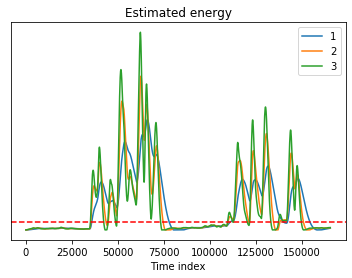

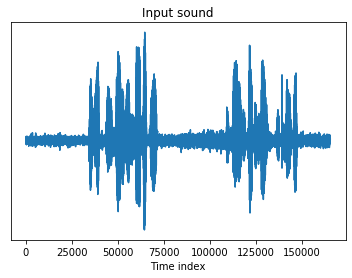

In [10]:
x_wind_sq = np.square(x_wind)
threshold = 0.0025

# Lowpass filter among different cutoff frequency
plt.figure(1)
plt.title('Estimated energy')
plt.xlabel('Time index')
plt.yticks([])
for cutoff_freq in range(1, 4, 1):
    b, a = signal.butter(2, cutoff_freq, 'lowpass', fs=fs_wind)
    e_wind = signal.lfilter(b, a, x_wind_sq)
    e_wind = e_wind.clip(min=0)
    plt.plot(e_wind, label=cutoff_freq)
plt.legend(loc='upper right')
# Threshold line
plt.axhline(y=threshold, color='r', linestyle='--')

plt.figure(2)
plt.title('Input sound')
plt.xlabel('Time index')
plt.yticks([])
plt.plot(x_wind)
plt.show()

In [11]:
def real_time_spectral_subtraction(x, e, threshold, num_noise_frame, alpha):    
    active = (e > threshold).astype(np.int) # 1 if over threshold, else 0
    
    ### Start to apply STFT ###
    # Zero padding to front and end of the input
    zero_padding = np.zeros(dft_size)
    x = np.append(zero_padding, x)
    x = np.append(x, zero_padding)
    # Align active signal with x
    active = np.append(zero_padding, active)
    active = np.append(active, zero_padding)

    # Segment into shorter frames
    frames = []
    active_frames = []
    for i in range(0, len(x)-dft_size, hop_size):
        # Apply analysis window
        frames.append(x[i:i+dft_size] * window)
        # True if there is a active signal in that frame, else False
        active_frames.append(np.any(active[i:i+dft_size]))

    X = []
    for frame in frames:
        freq_vec = np.reshape(np.fft.rfft(frame, dft_size+zero_pad), (-1, 1))
        f.append(freq_vec)

    for frame in frames:
        Xi = np.reshape(np.fft.rfft(frame, dft_size+zero_pad), (-1, 1))
        X.append(Xi)
    X = np.hstack(X)
    ### End of STFT ###

    noise_frame_counter = 0
    Y = []
    N = np.zeros((num_noise_frame, X.shape[0]), dtype=np.complex128) # noise spectrum shape=(frame, freq)
    for i in range(X.shape[1]):
        if active_frames[i]:
            N_avg = np.mean(np.abs(N), axis=0)
            magnitude = (np.abs(X[:, i]) - alpha * N_avg).clip(min=0)
            Yi = magnitude * np.exp(1j * np.angle(X[:, i]))
            Y.append(Yi)
        else: # under threshold, noise
            # Track noise frame
            N[noise_frame_counter] = X[:, i]
            noise_frame_counter = (noise_frame_counter + 1) % num_noise_frame
            # Set signal to 0
            Yi = np.zeros(X[:, i].shape[0])
            Y.append(Yi)
    Y = np.array(Y).T
    
    return Y

In [12]:
cutoff_freq = 3

b, a = signal.butter(2, cutoff_freq, 'lowpass', fs=fs_wind)
e_wind = signal.lfilter(b, a, x_wind_sq)
e_wind = e_wind.clip(min=0)

W_wind = real_time_spectral_subtraction(x_wind, e_wind, threshold, num_noise_frame=10, alpha=2)
w_wind = istft(W_wind, dft_size, hop_size, zero_pad, window=1/2)

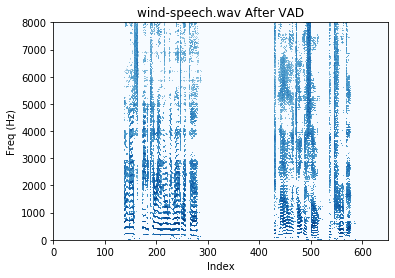

In [13]:
plot_spectrogram(x_wind, W_wind, fs_wind, 'wind-speech.wav After VAD', 1e-5)
sound(w_wind, fs_wind, 'wind-speech.wav After VAD')